# Detect the objects in test images 

This notebook is based on the [official Tensorflow Object Detection demo](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb) and only contains some slight changes. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
from copy import deepcopy
import pandas as pd

import seaborn as sns
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


## Env setup

In [13]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

In [4]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/label_map.pbtxt'

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Detection

In [10]:
def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                            feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
        'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

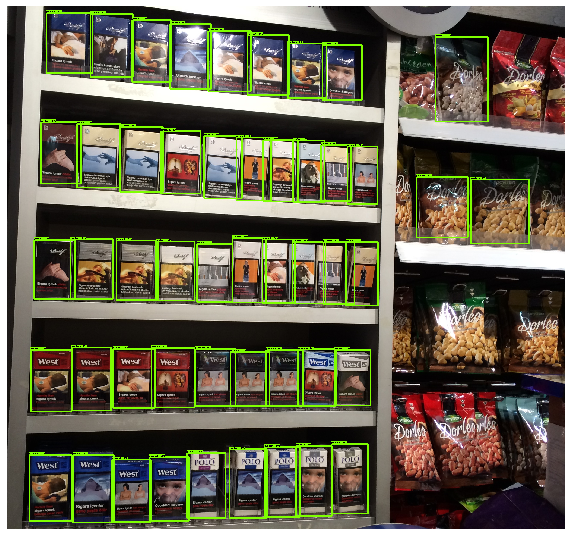

In [14]:
import cv2
try:
    with detection_graph.as_default():
        with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)

                
                image_np = cv2.cvtColor(cv2.imread('/home/paperspace/Desktop/grocery/ShelfImages/test/C1_P02_N1_S5_1.JPG'),cv2.COLOR_BGR2RGB)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                output_dict = run_inference_for_single_image(image_np, detection_graph)
                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    output_dict['detection_boxes'],
                    output_dict['detection_classes'],
                    output_dict['detection_scores'],
                    category_index,
                    instance_masks=output_dict.get('detection_masks'),
                    use_normalized_coordinates=True,
                    line_thickness=8, max_boxes_to_draw=False)
                plt.figure(figsize=(10,10))
                plt.imshow(image_np)
                plt.axis('off')
except Exception as e:
    print(e)

## Result folder

In [8]:
import os
# os.mkdir('Result_test/')

## Generation of image2product.json

In [53]:
output ={}
ids = os.listdir('/home/paperspace/Desktop/grocery/ShelfImages/test/')
for idd in ids:
    try:
        with detection_graph.as_default():
            with tf.Session() as sess:
                    # Get handles to input and output tensors
                    ops = tf.get_default_graph().get_operations()
                    all_tensor_names = {output.name for op in ops for output in op.outputs}
                    tensor_dict = {}
                    for key in [
                      'num_detections', 'detection_boxes', 'detection_scores',
                      'detection_classes', 'detection_masks'
                    ]:
                        tensor_name = key + ':0'
                        if tensor_name in all_tensor_names:
                            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                          tensor_name)

    #                 while True:
    #                     ret, image_np = cap.read()
                        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np = cv2.cvtColor(cv2.imread('/home/paperspace/Desktop/grocery/ShelfImages/test/'+idd),
                                            cv2.COLOR_BGR2RGB)
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                        # Actual detection.
                    output_dict = run_inference_for_single_image(image_np, detection_graph)
                        # Visualization of the results of a detection.
                    vis_util.visualize_boxes_and_labels_on_image_array(
                            image_np,
                            output_dict['detection_boxes'],
                            output_dict['detection_classes'],
                            output_dict['detection_scores'],
                            category_index,
                            instance_masks=output_dict.get('detection_masks'),
                            use_normalized_coordinates=True,
                            line_thickness=5,min_score_thresh=.5,max_boxes_to_draw=False)
                    cv2.imwrite('Result_test/'+idd,cv2.cvtColor(image_np,cv2.COLOR_RGB2BGR))
                    output[idd]= output_dict['detection_scores'][output_dict['detection_scores']>0.5].shape[0]
    #                 cv2.imshow('object_detection', cv2.resize(image_np, (800, 600)))
    except Exception as e:
        print(e)


In [ ]:
import json

with open('image2product.json', 'w') as fp:
    json.dump(output, fp)

## Peformance metrics calculation

In [11]:
import pandas as pd
test_labels = pd.read_csv('/home/paperspace/.local/lib/python3.7/site-packages/tensorflow/models/test_labels.csv')
test_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,C1_P02_N1_S5_1.JPG,2614,2448,product,1032,2080,1204,2408
1,C1_P02_N1_S5_1.JPG,2614,2448,product,1040,1092,1192,1392
2,C1_P02_N1_S5_1.JPG,2614,2448,product,1040,1600,1224,1892
3,C1_P02_N1_S5_1.JPG,2614,2448,product,1088,616,1236,920
4,C1_P02_N1_S5_1.JPG,2614,2448,product,1128,124,1308,436


### iou calculation

In [116]:
def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

### generation of grondtruth and detection results for mAP calculation

In [232]:
os.mkdir('ground_truth')
os.mkdir('detection_results')

In [14]:
ids = os.listdir('/home/paperspace/Desktop/grocery/ShelfImages/test/')
gt_folder ='ground_truth/'
pred_folder ='detection_results/'
Gt={}
pred={}
for idd in ids:
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_np = cv2.cvtColor(cv2.imread('/home/paperspace/Desktop/grocery/ShelfImages/test/'+idd),
                                        cv2.COLOR_BGR2RGB)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          # Each score represent how level of confidence for each of the objects.
          # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            box_pred = boxes[0][np.where(scores[scores>0.5])]
            scores_pred = scores[0][np.where(scores[scores>0.5])]
            box_true = test_labels[test_labels['filename']==idd].iloc[:,4:].values.tolist()
            height,width,c = image_np.shape
            scores_img=[]
            boxes_img=[]
            for i in range(len(box_pred)):
                ymin = int((box_pred[i][0]*height))
                xmin = int((box_pred[i][1]*width))
                ymax = int((box_pred[i][2]*height))
                xmax = int((box_pred[i][3]*width))
                line = 'Product '+str(scores_pred[i])+' '+str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)
                with open('detection_results/'+idd.split('.')[0]+'.txt', "a") as myfile:
                    myfile.write(line)
                    myfile.write('\n')
